In [60]:
import matplotlib.pyplot as plt
import numpy as np

In [67]:
def diff_sar_step(vip, vin, vref, k):
    d = None
    
    if vip > vin:
        d = 1
        vip = vip - vref / (2 ** k)
    else:
        d = 0
        vin = vin - vref / (2 ** k)

    return d, vip, vin

def diff_sar_step_monotonic(vip, vin, vref, k):
    if k > 4:
        return diff_sar_step(vip, vin, vref, k)

    d = None
    
    if vip >= vin:
        d = 1
        vip = vip - vref / (2 ** (k + 1))
        vin = vin + vref / (2 ** (k + 1))
    else:
        d = 0
        vin = vin - vref / (2 ** (k + 1))
        vip = vip + vref / (2 ** (k + 1))

    return d, vip, vin

In [62]:
k = 1
n = 8
vref = 1.8
vip = 1.0
vin = 0.8

vips =[vip, vip]
vins =[vin, vin]
ds = []

while k < n:
    d, vip, vin = diff_sar_step(vip, vin, vref, k)
    vips.append(vip)
    vins.append(vin)
    ds.append(d)
    k += 1

d, _, _ = diff_sar_step(vip, vin, vref, k)
ds.append(d)

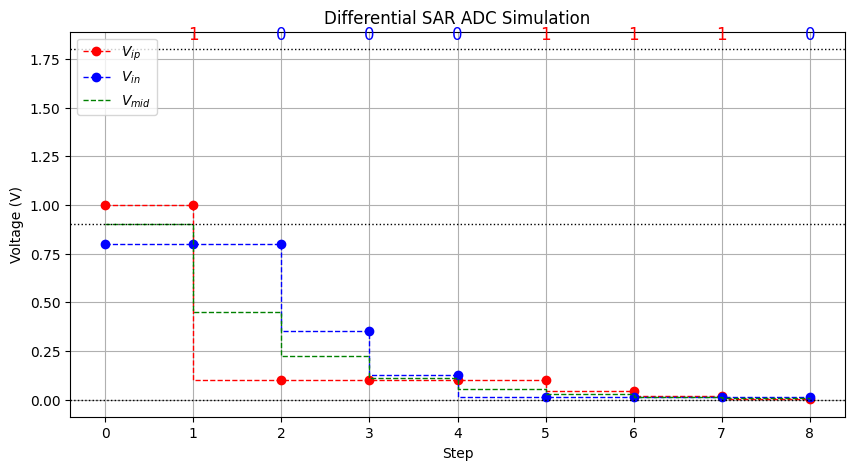

In [63]:
plt.figure(figsize=(10, 5))

# Plot the results
plt.plot(range(len(vips)), vips, label='$V_{{ip}}$', marker='o', drawstyle='steps-pre', linestyle='--', linewidth=1, color='red')
plt.plot(range(len(vins)), vins, label='$V_{{in}}$', marker='o', drawstyle='steps-pre', linestyle='--', linewidth=1, color='blue')
plt.plot(range(len(vins)), [(vip + vin) / 2 for vip, vin in zip(vips, vins)], label='$V_{{mid}}$', drawstyle='steps-pre', linestyle='--', linewidth=1, color='green')

# Add reference voltage lines
plt.axhline(y=vref, color='black', linestyle=':', linewidth=1)
plt.axhline(y=vref/2, color='black', linestyle=':', linewidth=1)
plt.axhline(y=0, color='black', linestyle=':', linewidth=1)

# Add step markers for decisions
for i, d in enumerate(ds):
    if d == 1:
        plt.text(i + 1, vref + 0.05, '1', fontsize=12, ha='center', color='red')
    else:
        plt.text(i + 1, vref + 0.05, '0', fontsize=12, ha='center', color='blue')


plt.title('Differential SAR ADC Simulation')
plt.xlabel('Step')
plt.ylabel('Voltage (V)')
plt.xticks(range(len(vips)))
plt.grid()
plt.legend()
plt.show()

In [64]:
k = 1
n = 8
vref = 1.8
vip = 1.0
vin = 0.8

vips =[vip, vip]
vins =[vin, vin]
ds = []

while k < n:
    d, vip, vin = diff_sar_step_monotonic(vip, vin, vref, k)
    vips.append(vip)
    vins.append(vin)
    ds.append(d)
    k += 1

d, _, _ = diff_sar_step_monotonic(vip, vin, vref, k)
ds.append(d)

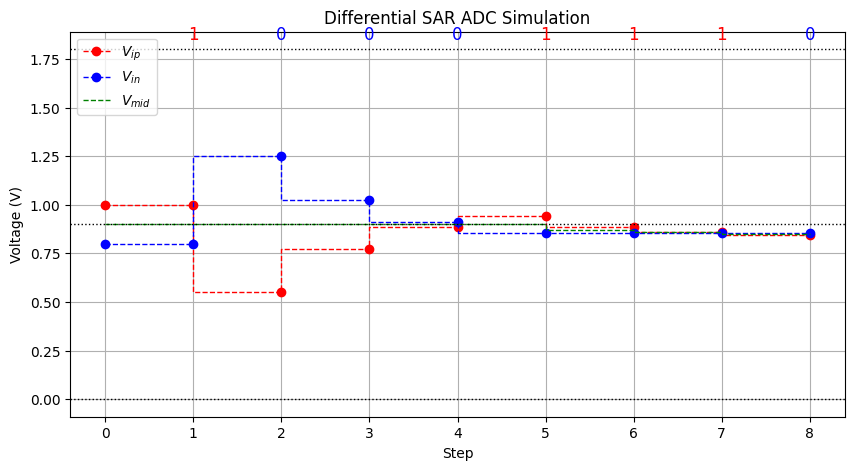

In [65]:
plt.figure(figsize=(10, 5))

# Plot the results
plt.plot(range(len(vips)), vips, label='$V_{{ip}}$', marker='o', drawstyle='steps-pre', linestyle='--', linewidth=1, color='red')
plt.plot(range(len(vins)), vins, label='$V_{{in}}$', marker='o', drawstyle='steps-pre', linestyle='--', linewidth=1, color='blue')
plt.plot(range(len(vins)), [(vip + vin) / 2 for vip, vin in zip(vips, vins)], label='$V_{{mid}}$', drawstyle='steps-pre', linestyle='--', linewidth=1, color='green')

# Add reference voltage lines
plt.axhline(y=vref, color='black', linestyle=':', linewidth=1)
plt.axhline(y=vref/2, color='black', linestyle=':', linewidth=1)
plt.axhline(y=0, color='black', linestyle=':', linewidth=1)

# Add step markers for decisions
for i, d in enumerate(ds):
    if d == 1:
        plt.text(i + 1, vref + 0.05, '1', fontsize=12, ha='center', color='red')
    else:
        plt.text(i + 1, vref + 0.05, '0', fontsize=12, ha='center', color='blue')


plt.title('Differential SAR ADC Simulation')
plt.xlabel('Step')
plt.ylabel('Voltage (V)')
plt.xticks(range(len(vips)))
plt.grid()
plt.legend()
plt.show()

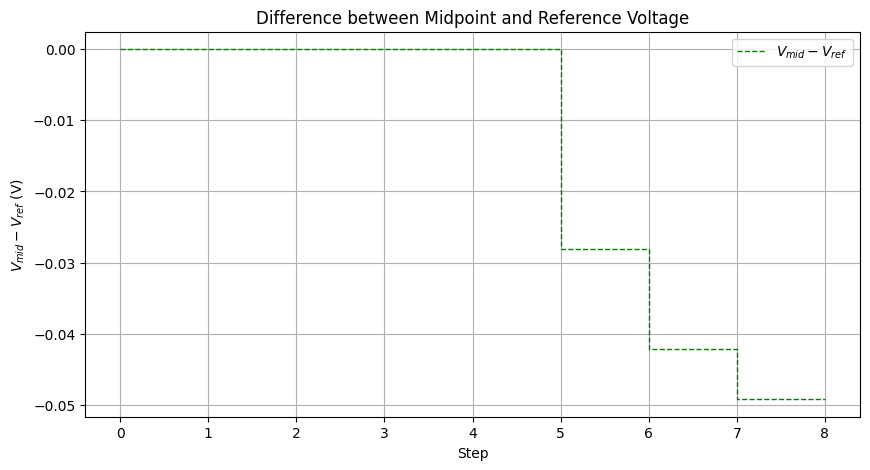

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(vins)), [(vip + vin) / 2 - vref / 2 for vip, vin in zip(vips, vins)], label='$V_{{mid}} - V_{{ref}}$', drawstyle='steps-pre', linestyle='--', linewidth=1, color='green')
plt.title('Difference between Midpoint and Reference Voltage')
plt.xlabel('Step')
plt.ylabel('$V_{{mid}} - V_{{ref}}$ (V)')
plt.xticks(range(len(vins)))
plt.grid()
plt.legend()
plt.show()